## Figure pool time series

In [67]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [68]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [69]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

In [70]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileA)
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileB)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))
sb_curv_A = np.empty(len(labels))
sb_curv_B = np.empty(len(labels))
sb_grad_A = np.empty(len(labels))
sb_grad_B = np.empty(len(labels))
sb_curv0_A = np.empty(len(labels))
sb_curv0_B = np.empty(len(labels))
sb_grad0_A = np.empty(len(labels))
sb_grad0_B = np.empty(len(labels))
sb_curvtop_A = np.empty(len(labels))
sb_curvtop_B = np.empty(len(labels))
sb_gradtop_A = np.empty(len(labels))
sb_gradtop_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array,grad_array,curv_array,grad0_array,curv0_array,\
    gradtop_array,curvtop_array,sb_ind,drc,state in zip([ptr_fileA, ptr_fileB],
                                                        [sb_conc_A, sb_conc_B],
                                                        [sb_grad_A, sb_grad_B],
                                                        [sb_curv_A, sb_curv_B],
                                                        [sb_grad0_A, sb_grad0_B],
                                                        [sb_curv0_A, sb_curv0_B],
                                                        [sb_gradtop_A, sb_gradtop_B],
                                                        [sb_curvtop_A, sb_curvtop_B],
                                                        [sb_Ast, sb_Bar],
                                                        [drC_A, drC_B],
                                                        [stateA, stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180] # nM to muM
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = density.data*profile.data/1000 # mumol/kg muM to 
            else:
                tr_profile = nbl.variables[trac][0,:,10,180] # muM
            
            tr_curv = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drc[3:]*drc[1:-2])
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
                
            sb_array[ii] = tr_profile[sb_ind]
            curv_array[ii] = np.nanmean(tr_curv[sb_ind-8:sb_ind+8]) # background mean 
            curvtop_array[ii] = np.nanmean(tr_curv[sb_ind-8:sb_ind]) # above canyon mean
            curv0_array[ii] = np.nanmean(tr_curv[sb_ind-1:sb_ind+5]) # local mean
            grad_array[ii] = np.nanmean(tr_grad[sb_ind-8:sb_ind+8])
            gradtop_array[ii] = np.nanmean(tr_grad[sb_ind-8:sb_ind]) 
            grad0_array[ii] = np.nanmean(tr_grad[sb_ind-1:sb_ind+5]) 
                        

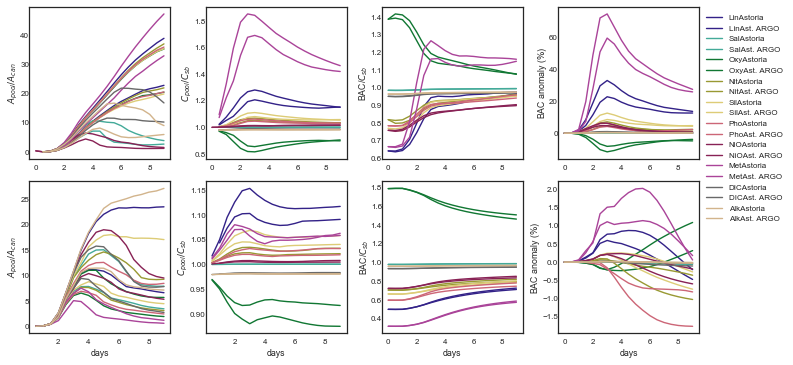

In [71]:
sns.set_style('white')
fig=plt.figure(figsize=(12,6))

gs = gspec.GridSpec(2, 4, hspace=0.15,wspace=0.25)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
   
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
nt = 19
labels_exp = ['Astoria', 'Ast. ARGO', 'Barkley', 'Bar. Path.']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']
units = ['(muM)m3/s','PSU','(umol/kg)m3/s','(muM)m3/s','(muM)m3/s','muM)m3/s','(nM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s','(umol/kg)m3/s']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]


exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']

exp_files_BAC = ['../saved_calcs/BAC_AST.nc',
                 '../saved_calcs/BAC_ARGO.nc',
                 '../saved_calcs/BAC_BAR.nc',
                 '../saved_calcs/BAC_PATH.nc']


can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, range(len(units)),
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area, sb_c in zip(exp_files, exp_files_BAC, labels_exp, can_Area, sb_conc):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            conc = nbl.variables['conc']
            if can_area > 8.8E7:
                ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+lab_exp) 
                ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp)
            else:
                ax4.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+lab_exp)
                ax5.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp)
        
        with Dataset(file_bac,'r') as nbl:
            bac = nbl.variables['bac']
            bac_noc = nbl.variables['bac_noc']
            if can_area > 9E7:
                ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp)
                ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
                             color = col, label = tr_lab+lab_exp)
            else:
                ax6.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp) 
                ax7.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
                             color = col, label = tr_lab+lab_exp)

ylabels = ['$A_{pool}/A_{can}$', '$C_{pool}/C_{sb}$','BAC/$C_{sb}$', 'BAC anomaly ($\%$)' ]

for ax,ylab in zip([ax0,ax1,ax2,ax3], ylabels): 
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=0)
    ax.yaxis.set_tick_params(pad=0.1)
for ax,ylab in zip([ax4,ax5,ax6,ax7], ylabels): 
    ax.set_xlabel('days')
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=0)
    ax.yaxis.set_tick_params(pad=0)
    

ax3.legend(bbox_to_anchor=(1,1))

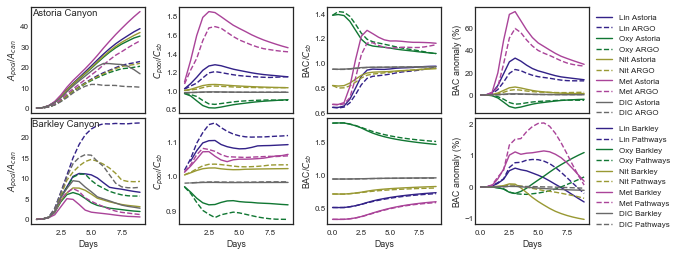

In [72]:
sns.set_style('white')
sns.set_context('paper')
fig=plt.figure(figsize=(10,4))

gs = gspec.GridSpec(2, 4, hspace=0.05,wspace=0.3)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
   
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
nt = 19
labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']


factors = [1,1,1,1E-3,1]


exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']

exp_files_BAC = ['../saved_calcs/BAC_AST.nc',
                 '../saved_calcs/BAC_ARGO.nc',
                 '../saved_calcs/BAC_BAR.nc',
                 '../saved_calcs/BAC_PATH.nc']

colours = ['#332288','#117733','#999933','#AA4499','dimgray']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, [0,2,3,7,8],
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area, sb_c in zip(exp_files, exp_files_BAC, labels_exp, can_Area, sb_conc):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            conc = nbl.variables['conc']
            if can_area > 8.8E7:
                if lab_exp=='Astoria':
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+''+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+''+lab_exp)
                else:
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, label = tr_lab+''+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+''+lab_exp)
            else:
                if lab_exp=='Barkley':
                    ax4.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+''+lab_exp)
                    ax5.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+''+lab_exp)
                else:
                    ax4.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, label = tr_lab+''+lab_exp)
                    ax5.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+''+lab_exp)
        
        
        with Dataset(file_bac,'r') as nbl:
            bac = nbl.variables['bac']
            bac_noc = nbl.variables['bac_noc']
            if can_area > 9E7:
                if lab_exp=='Astoria':
                    ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp)
                    ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
                                 color = col, label = tr_lab+' '+lab_exp)
                else:
                    ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+lab_exp)
                    ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '--',
                                 color = col, label = tr_lab+' '+lab_exp)
            else:
                if lab_exp=='Barkley':
                    ax6.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp) 
                    ax7.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
                                 color = col, label = tr_lab+' '+lab_exp)
                else:
                    ax6.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+lab_exp) 
                    ax7.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '--',
                                 color = col, label = tr_lab+' '+lab_exp)
                    

ylabels = ['$A_{pool}/A_{can}$', '$C_{pool}/C_{sb}$','BAC/$C_{sb}$', 'BAC anomaly ($\%$)' ]

for ax,ylab in zip([ax0,ax1,ax2,ax3], ylabels): 
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=0)
    ax.yaxis.set_tick_params(pad=2)
    ax.xaxis.set_ticks([])
for ax,ylab in zip([ax4,ax5,ax6,ax7], ylabels): 
    ax.set_xlabel('Days')
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=0)
    ax.yaxis.set_tick_params(pad=2)

ax3.legend(bbox_to_anchor=(1,1))
ax7.legend(bbox_to_anchor=(1,1))

ax0.text(0.01,0.92,'Astoria Canyon',transform=ax0.transAxes)    
ax4.text(0.01,0.92,'Barkley Canyon',transform=ax4.transAxes)    

plt.savefig('fig_pool_ts.eps',format='eps', bbox_inches='tight')

### Plots for talks

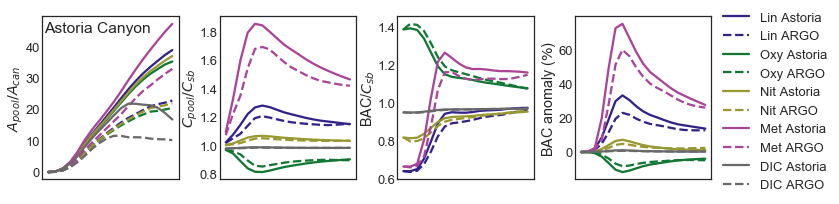

In [73]:
sns.set_style('white')
sns.set_context('talk')

fig=plt.figure(figsize=(12,3))

gs = gspec.GridSpec(1, 4, hspace=0.05,wspace=0.3)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
   
axs = [ax0,ax1,ax2,ax3]
nt = 19
labels_exp = ['Astoria', 'ARGO']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']


factors = [1,1,1,1E-3,1]


exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             ]

exp_files_BAC = ['../saved_calcs/BAC_AST.nc',
                 '../saved_calcs/BAC_ARGO.nc',
                ]

colours = ['#332288','#117733','#999933','#AA4499', 'dimgray']

can_Area = [1.8E8, 1.8E8]
sb_conc = [sb_conc_A, sb_conc_A]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, [0,2,3,7,8],
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area, sb_c in zip(exp_files, exp_files_BAC, labels_exp, can_Area, sb_conc):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            conc = nbl.variables['conc']
            if can_area > 8.8E7:
                if lab_exp=='Astoria':
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+''+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+''+lab_exp)
                else:
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, label = tr_lab+''+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+''+lab_exp)
           
        
        with Dataset(file_bac,'r') as nbl:
            bac = nbl.variables['bac']
            bac_noc = nbl.variables['bac_noc']
            if can_area > 9E7:
                if lab_exp=='Astoria':
                    ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp)
                    ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
                                 color = col, label = tr_lab+' '+lab_exp)
                else:
                    ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+lab_exp)
                    ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '--',
                                 color = col, label = tr_lab+' '+lab_exp)             

ylabels = ['$A_{pool}/A_{can}$', '$C_{pool}/C_{sb}$','BAC/$C_{sb}$', 'BAC anomaly ($\%$)' ]

for ax,ylab in zip([ax0,ax1,ax2,ax3], ylabels): 
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=0)
    ax.yaxis.set_tick_params(pad=2)
    ax.xaxis.set_ticks([])

ax3.legend(bbox_to_anchor=(1,1.1))
ax0.text(0.015,0.9,'Astoria Canyon',transform=ax0.transAxes)    

plt.savefig('fig_pool_ts_Astoria.eps',format='eps', bbox_inches='tight')

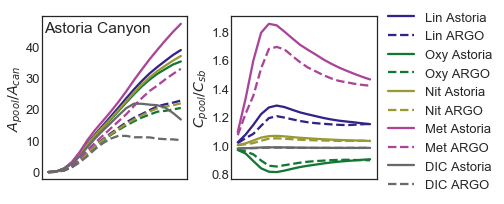

In [74]:
sns.set_style('white')
sns.set_context('talk')

fig=plt.figure(figsize=(6,3))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.3)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
   
axs = [ax0,ax1]
nt = 19
labels_exp = ['Astoria', 'ARGO']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']


factors = [1,1,1,1E-3,1]


exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             ]

exp_files_BAC = ['../saved_calcs/BAC_AST.nc',
                 '../saved_calcs/BAC_ARGO.nc',
                ]

colours = ['#332288','#117733','#999933','#AA4499', 'dimgray']

can_Area = [1.8E8, 1.8E8]
sb_conc = [sb_conc_A, sb_conc_A]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, [0,2,3,7,8],
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area, sb_c in zip(exp_files, exp_files_BAC, labels_exp, can_Area, sb_conc):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            conc = nbl.variables['conc']
            if can_area > 8.8E7:
                if lab_exp=='Astoria':
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+' '+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+' '+lab_exp)
                else:
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, label = tr_lab+' '+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+' '+lab_exp)
           
ylabels = ['$A_{pool}/A_{can}$', '$C_{pool}/C_{sb}$' ]

for ax,ylab in zip([ax0,ax1], ylabels): 
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=0)
    ax.yaxis.set_tick_params(pad=2)
    ax.xaxis.set_ticks([])

ax1.legend(bbox_to_anchor=(1,1.1))
ax0.text(0.015,0.9,'Astoria Canyon',transform=ax0.transAxes)    

plt.savefig('fig_pool_ts_Astoria_pool_only.eps',format='eps', bbox_inches='tight')

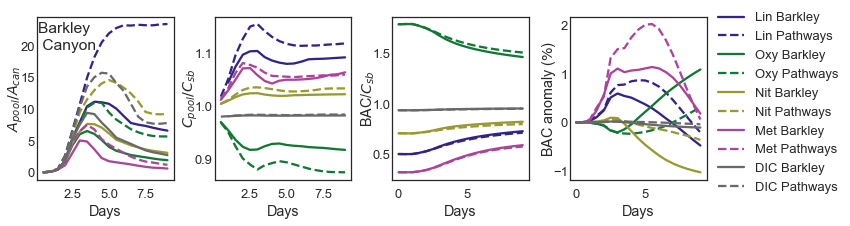

In [75]:
sns.set_style('white')
sns.set_context('talk')
fig=plt.figure(figsize=(12,3))

gs = gspec.GridSpec(1, 4, hspace=0.05,wspace=0.3)

ax4 = plt.subplot(gs[0])
ax5 = plt.subplot(gs[1])
ax6 = plt.subplot(gs[2])
ax7 = plt.subplot(gs[3])
   
axs = [ax4,ax5,ax6,ax7]
nt = 19
labels_exp = [ 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']


factors = [1,1,1,1E-3,1]


exp_files = ['../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']

exp_files_BAC = ['../saved_calcs/BAC_BAR.nc',
                 '../saved_calcs/BAC_PATH.nc']

colours = ['#332288','#117733','#999933','#AA4499', 'dimgray']

can_Area = [8.7E7, 8.7E7]
sb_conc = [sb_conc_B, sb_conc_B]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, [0,2,3,7,8],
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area, sb_c in zip(exp_files, exp_files_BAC, labels_exp, can_Area, sb_conc):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            conc = nbl.variables['conc']
            if can_area > 8.8E7:
                if lab_exp=='Astoria':
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+''+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+''+lab_exp)
                else:
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, label = tr_lab+''+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+''+lab_exp)
            else:
                if lab_exp=='Barkley':
                    ax4.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+''+lab_exp)
                    ax5.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+''+lab_exp)
                else:
                    ax4.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, label = tr_lab+''+lab_exp)
                    ax5.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+''+lab_exp)
        
        
        with Dataset(file_bac,'r') as nbl:
            bac = nbl.variables['bac']
            bac_noc = nbl.variables['bac_noc']
            if can_area > 9E7:
                if lab_exp=='Astoria':
                    ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp)
                    ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
                                 color = col, label = tr_lab+' '+lab_exp)
                else:
                    ax2.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+lab_exp)
                    ax3.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '--',
                                 color = col, label = tr_lab+' '+lab_exp)
            else:
                if lab_exp=='Barkley':
                    ax6.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+lab_exp) 
                    ax7.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '-',
                                 color = col, label = tr_lab+' '+lab_exp)
                else:
                    ax6.plot(np.arange(nt)/2,bac[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+lab_exp) 
                    ax7.plot(np.arange(nt)/2,100*(bac[ii,:]-bac_noc[ii,:])/bac_noc[ii,:], '--',
                                 color = col, label = tr_lab+' '+lab_exp)
                    

ylabels = ['$A_{pool}/A_{can}$', '$C_{pool}/C_{sb}$','BAC/$C_{sb}$', 'BAC anomaly ($\%$)' ]

for ax,ylab in zip([ax4,ax5,ax6,ax7], ylabels): 
    ax.set_xlabel('Days')
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=-5)
    ax.yaxis.set_tick_params(pad=2)

ax7.legend(bbox_to_anchor=(1,1.1))

ax4.text(0.01,0.8,'Barkley \n Canyon',transform=ax4.transAxes)    

plt.savefig('fig_pool_ts_Barkley.eps',format='eps', bbox_inches='tight')

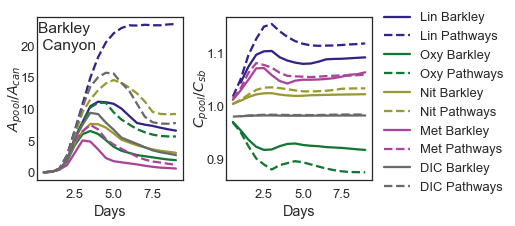

In [76]:
sns.set_style('white')
sns.set_context('talk')
fig=plt.figure(figsize=(6,3))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.3)

ax4 = plt.subplot(gs[0])
ax5 = plt.subplot(gs[1])
   
axs = [ax4,ax5]
nt = 19
labels_exp = [ 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']


factors = [1,1,1,1E-3,1]


exp_files = ['../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']

exp_files_BAC = ['../saved_calcs/BAC_BAR.nc',
                 '../saved_calcs/BAC_PATH.nc']

colours = ['#332288','#117733','#999933','#AA4499', 'dimgray']

can_Area = [8.7E7, 8.7E7]
sb_conc = [sb_conc_B, sb_conc_B]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, [0,2,3,7,8],
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area, sb_c in zip(exp_files, exp_files_BAC, labels_exp, can_Area, sb_conc):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            conc = nbl.variables['conc']
            if can_area > 8.8E7:
                if lab_exp=='Astoria':
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+' '+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+' '+lab_exp)
                else:
                    ax0.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, label = tr_lab+' '+lab_exp) 
                    ax1.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+' '+lab_exp)
            else:
                if lab_exp=='Barkley':
                    ax4.plot(np.arange(nt)/2,area[ii,:]/can_area, '-', color = col, label = tr_lab+' '+lab_exp)
                    ax5.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '-', color = col, label = tr_lab+' '+lab_exp)
                else:
                    ax4.plot(np.arange(nt)/2,area[ii,:]/can_area, '--', color = col, label = tr_lab+' '+lab_exp)
                    ax5.plot(np.arange(nt)/2,conc[ii,:]*factor/sb_c[ii], '--', color = col, label = tr_lab+' '+lab_exp)
        
                    

ylabels = ['$A_{pool}/A_{can}$', '$C_{pool}/C_{sb}$' ]

for ax,ylab in zip([ax4,ax5], ylabels): 
    ax.set_xlabel('Days')
    ax.set_ylabel(ylab)
    ax.set_ylabel(ylab, labelpad=-5)
    ax.yaxis.set_tick_params(pad=2)

ax5.legend(bbox_to_anchor=(1,1.1))

ax4.text(0.01,0.8,'Barkley \n Canyon',transform=ax4.transAxes)    

plt.savefig('fig_pool_ts_Barkley_pool_only.eps',format='eps', bbox_inches='tight')

### Plot area vs curvature

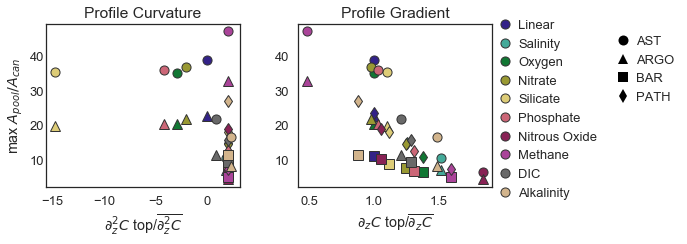

In [77]:
sns.set_style('white')
sns.set_context('talk')
fig=plt.figure(figsize=(8,3))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.3)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
   
labels_exp = ['Astoria', 'Ast. ARGO','Barkley', 'Bar. Path.']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
units = ['(muM)m3/s','PSU','(umol/kg)m3/s','(muM)m3/s','(muM)m3/s','muM)m3/s','(nM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s','(umol/kg)m3/s']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]


exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']

exp_files_BAC = ['../saved_calcs/BAC_AST.nc',
                 '../saved_calcs/BAC_ARGO.nc',
                 '../saved_calcs/BAC_BAR.nc',
                 '../saved_calcs/BAC_PATH.nc']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_curv = [sb_curv_A,sb_curv_A, sb_curv_B,sb_curv_B]
sb_grad = [sb_grad_A,sb_grad_A, sb_grad_B,sb_grad_B]
sb_curvtop = [sb_curvtop_A,sb_curvtop_A, sb_curvtop_B,sb_curvtop_B]
sb_gradtop = [sb_gradtop_A,sb_gradtop_A, sb_gradtop_B,sb_gradtop_B]

for tr, unit, tr_lab, factor, ii, trac, col in zip(tracers, units, labels_tra, factors, range(len(labels_tra)),
                                                   tracers, colours):
    for file,file_bac, lab_exp, can_area,grad, curv,grad0, curv0 in zip(exp_files, 
                                                                        exp_files_BAC, 
                                                                        labels_exp, 
                                                                        can_Area,
                                                                        sb_grad, 
                                                                        sb_curv,
                                                                        sb_gradtop, 
                                                                        sb_curvtop):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='Astoria':
                    ax0.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 'o', 
                             mfc = col, mec='0.2',mew=1, label = tr_lab)
                    ax1.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 'o', 
                             mfc = col, mec='0.2',mew=1 )
                    
                else:
                    ax0.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, '^', 
                             mfc = col, mec='0.2',mew=1) 
                    ax1.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, '^', 
                             mfc = col, mec='0.2',mew=1)
            else:
                if lab_exp=='Barkley':
                    ax0.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 's', 
                             mfc = col, mec='0.2',mew=1)
                    ax1.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 's', 
                             mfc = col, mec='0.2',mew=1)
                else:
                    ax0.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 'd', 
                             mfc = col, mec='0.2',mew=1)
                    ax1.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 'd', 
                             mfc = col, mec='0.2',mew=1)
                 
                    

ax0.set_xlabel(r'$\partial^2_zC$ top/$\overline{\partial^2_zC}$')
ax1.set_xlabel(r'$\partial_zC$ top/$\overline{\partial_zC}$')
ax0.set_title('Profile Curvature')
ax1.set_title('Profile Gradient')
ax0.set_ylabel('max $A_{pool}/A_{can}$')
ax0.yaxis.set_tick_params(pad=2)
ax0.legend(bbox_to_anchor=(2.9,1.1), handletextpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=10),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=10),
                   ]


ax1.legend(handles=legend_elements, bbox_to_anchor=(2,1), handletextpad=0)


plt.savefig('poolArea_vs_curvature.eps',format='eps', bbox_inches='tight')

In [78]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

def Z(U,f,L,W,N,s):
    '''depth of upwelling as in Howatt and Allen 2013'''
    return(1.8*(F(Ro(U,f,W))*Ro(U,f,L))**(0.5) *(1-0.42*SE(s,N,f,F(Ro(U,f,W)),Ro(U,f,L)))+0.05)

g = 9.81 # accel. gravity
s = np.array([0.00230,0.00230,0.00454,0.00454]) # shelf slope 
N = np.array([0.0055,0.0088,0.0055,0.0038]) # Initial at 152.5 m
f = np.array([1.0E-4,1.05E-4,1.0E-4,1.08E-4])
U = np.array([0.3,0.329,0.3,0.288])
Wiso = np.array([8900,8900,8300,8300])
L = np.array([21800,21800,6400,6400])


152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938


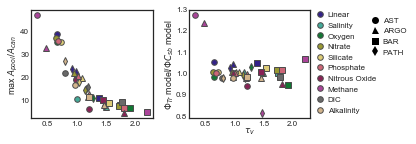

In [79]:
sns.set_style('white')
sns.set_context('paper')
fig=plt.figure(figsize=(5,2))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.3)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_curv0 = [sb_curv0_A,sb_curv0_A, sb_curv0_B,sb_curv0_B]
sb_grad = [sb_grad_A,sb_grad_A, sb_grad_B,sb_grad_B]
sb_curvtop = [sb_curvtop_A,sb_curvtop_A, sb_curvtop_B,sb_curvtop_B]
sb_gradtop = [sb_gradtop_A,sb_gradtop_A, sb_gradtop_B,sb_gradtop_B]

for tr, tr_lab, factor, ii, col in zip(tracers, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run, lab_exp, can_area,exp,grad,gradbk,conc,ff,nn,uu,ll,ww,ss, mark in zip(exp_files, 
                                                                                        runs,
                                                                                        labels_exp,
                                                                                        can_Area,exps,
                                                                                        sb_gradtop,sb_grad,
                                                                                        sb_conc,
                                                                                        f,N,U,L,Wiso,s,
                                                                                        markers):
        Cs=conc[ii]
        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        tau_v = (100*grad[ii])/(ZZ*gradbk[ii])#-ZZ*curv[ii]/grad[ii]
        print(ZZ)
        
        # Plot Phi_Tr vs tau   
        file2 = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s_%s.csv' %(exp,tr, run))
        df = pd.read_csv(file2)
        if (tr == 'Tr07' or tr == 'Tr08'):
            TrMass = df['TrMassHCW'][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['HCW'][:]# m^3 to l
        else:
            TrMass = 1E3*df['TrMassHCW'][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['HCW'][:]# m^3 to l
        
        PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        
        ax1.plot(tau_v,PhiTr/(Phi*Cs), marker=mark,markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1)
        
        # Plot area vs tau
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(tau_v,np.nanmax(area[ii,:])/can_area, 'o', mfc = col, mec='0.3',mew=1, label = tr_lab)
                    
                else:
                    ax0.plot(tau_v,np.nanmax(area[ii,:])/can_area, '^', mfc = col, mec='0.3',mew=1) 
                    
            else:
                if lab_exp=='BAR':
                    ax0.plot(tau_v,np.nanmax(area[ii,:])/can_area, 's', mfc = col, mec='0.3',mew=1)
                    
                else:
                    ax0.plot(tau_v,np.nanmax(area[ii,:])/can_area, 'd', mfc = col, mec='0.3',mew=1)
                    
        
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)

ax0.legend(bbox_to_anchor=(2.9,1.05), handletextpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]


ax1.legend(handles=legend_elements, bbox_to_anchor=(1.85,1), handletextpad=0)

ax1.set_xlabel(r'$\tau_v$', labelpad=0)
ax0.set_ylabel('max $A_{pool}/A_{can}$', labelpad=0)
ax1.set_ylabel('$\Phi_{Tr}$ model/$\Phi C_{sb}$ model', labelpad=0)
#ax0.text(0.03,0.055,'(a)',fontweight='bold',transform=ax0.transAxes,bbox=dict(boxstyle="square",
                                                                             #ec='0.8',
                                                                             #fc='0.8'))
#ax1.text(0.03,0.055,'(b)',fontweight='bold',transform=ax1.transAxes,bbox=dict(boxstyle="square",
                                                                             #ec='0.8',
                                                                             #fc='0.8'))

plt.savefig('tauv_vs_pool_PhiTr.eps',format='eps', bbox_inches='tight')

152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938
152.75647975521744
101.68275121498665
72.2837154421153
108.34072862294938


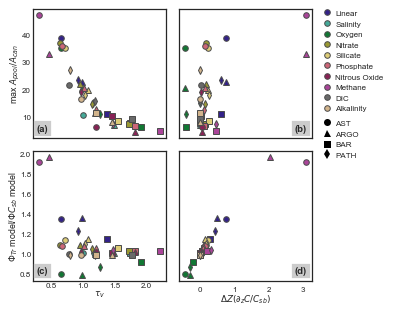

In [80]:
sns.set_style('white')
sns.set_context('paper')
fig=plt.figure(figsize=(5,5))

gs = gspec.GridSpec(2, 2, hspace=0.1,wspace=0.1)

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[1,1])
ax3 = plt.subplot(gs[0,1])
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_curv0 = [sb_curv0_A,sb_curv0_A, sb_curv0_B,sb_curv0_B]
sb_grad0 = [sb_grad0_A,sb_grad0_A, sb_grad0_B,sb_grad0_B]
sb_curv = [sb_curv_A,sb_curv_A, sb_curv_B,sb_curv_B]
sb_grad = [sb_grad_A,sb_grad_A, sb_grad_B,sb_grad_B]
sb_curvtop = [sb_curvtop_A,sb_curvtop_A, sb_curvtop_B,sb_curvtop_B]
sb_gradtop = [sb_gradtop_A,sb_gradtop_A, sb_gradtop_B,sb_gradtop_B]

for tr, tr_lab, factor, ii, col in zip(tracer_keys, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run,run_phi,lab_exp, can_area,exp, \
    grad0,curv0,grad,curv,gradtop,curvtop,conc,ff,nn,uu,ll,ww,ss, mark in zip(exp_files, 
                                                                              runs,runs_phi,
                                                                              labels_exp,
                                                                              can_Area,exps,
                                                                              sb_grad0,sb_curv0,
                                                                              sb_grad,sb_curv,
                                                                              sb_gradtop,sb_curvtop,
                                                                              sb_conc,
                                                                              f,N,U,L,Wiso,s,
                                                                              markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        tau_v = -ZZ*curv0[ii]/grad0[ii]
        Cs=conc[ii]
        print(ZZ)
        
         
        # Plot area vs tau
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(100*gradtop[ii]/(ZZ*grad[ii]),np.nanmax(area[ii,:])/can_area, 'o', mfc = col, mec='0.3',mew=1, label = tr_lab)
                    ax3.plot(10*grad0[ii]/Cs,np.nanmax(area[ii,:])/can_area, 'o', mfc = col, mec='0.3',mew=1, label = tr_lab)
                    
                else:
                    ax0.plot(100*gradtop[ii]/(ZZ*grad[ii]),np.nanmax(area[ii,:])/can_area, '^', mfc = col, mec='0.3',mew=1) 
                    ax3.plot(10*grad0[ii]/Cs,np.nanmax(area[ii,:])/can_area, '^', mfc = col, mec='0.3',mew=1) 
                    
            else:
                if lab_exp=='BAR':
                    ax0.plot(100*gradtop[ii]/(ZZ*grad[ii]),np.nanmax(area[ii,:])/can_area, 's', mfc = col, mec='0.3',mew=1)
                    ax3.plot(10*grad0[ii]/Cs,np.nanmax(area[ii,:])/can_area, 's', mfc = col, mec='0.3',mew=1)
                    
                else:
                    ax0.plot(100*gradtop[ii]/(ZZ*grad[ii]),np.nanmax(area[ii,:])/can_area, 'd', mfc = col, mec='0.3',mew=1)
                    ax3.plot(10*grad0[ii]/Cs,np.nanmax(area[ii,:])/can_area, 'd', mfc = col, mec='0.3',mew=1)
                    
        # Plot Phi_Tr vs tau   
        file = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file)
        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['Phi'][:]# m^3 to l
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = 1000*df['Phi'][:]# m^3 to l
        
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
        ax1.plot(100*gradtop[ii]/(ZZ*grad[ii]),PhiTr/(Phi*Cs), marker=mark,markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1)
        ax2.plot(ZZ*grad0[ii]/Cs,PhiTr/(Phi*Cs), marker=mark,markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1)
       
         
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)
ax0.xaxis.set_ticks([])
ax3.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax3.yaxis.set_ticks([])

ax3.legend(bbox_to_anchor=(1,1.05), handletextpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]


ax2.legend(handles=legend_elements, bbox_to_anchor=(1,1.3), handletextpad=0)
ax2.set_xlabel(r'$\Delta Z(\partial_zC/C_{sb})$', labelpad=0)
ax1.set_xlabel(r'$\tau_v$', labelpad=0)

ax0.set_ylabel('max $A_{pool}/A_{can}$', labelpad=0)
ax1.set_ylabel('$\Phi_{Tr}$ model/$\Phi C_{sb}$ model', labelpad=0)

ax0.text(0.03,0.055,'(a)',fontweight='bold',transform=ax0.transAxes,bbox=dict(boxstyle="square",
                                                                             ec='0.8',
                                                                             fc='0.8'))
ax1.text(0.03,0.055,'(c)',fontweight='bold',transform=ax1.transAxes,bbox=dict(boxstyle="square",
                                                                             ec='0.8',
                                                                             fc='0.8'))
ax2.text(0.87,0.055,'(d)',fontweight='bold',transform=ax2.transAxes,bbox=dict(boxstyle="square",
                                                                             ec='0.8',
                                                                             fc='0.8'))
ax3.text(0.87,0.055,'(b)',fontweight='bold',transform=ax3.transAxes,bbox=dict(boxstyle="square",
                                                                             ec='0.8',
                                                                             fc='0.8'))

plt.savefig('tauv_vs_pool_PhiTr.eps',format='eps', bbox_inches='tight')

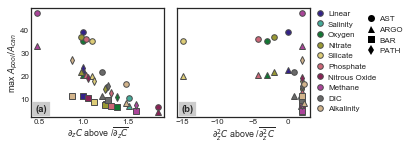

In [81]:
sns.set_style('white')
sns.set_context('paper')
fig=plt.figure(figsize=(5,2))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.1)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]

for tr, tr_lab, factor, ii, col in zip(tracers, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run, lab_exp, can_area,exp,grad,curv,grad0,curv0 in zip(exp_files, 
                                                                      runs,
                                                                      labels_exp,
                                                                      can_Area,exps,
                                                                      sb_grad, sb_curv,
                                                                      sb_gradtop, sb_curvtop):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 'o', mfc = col, mec='0.3',mew=1, label = tr_lab)
                    ax1.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 'o', mfc = col, mec='0.3',mew=1, label = tr_lab)
                    
                else:
                    ax0.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, '^', mfc = col, mec='0.3',mew=1) 
                    ax1.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, '^', mfc = col, mec='0.3',mew=1) 
                    
            else:
                if lab_exp=='BAR':
                    ax0.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 's', mfc = col, mec='0.3',mew=1) 
                    ax1.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 's', mfc = col, mec='0.3',mew=1) 
                    
                else:
                    ax0.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 'd', mfc = col, mec='0.3',mew=1) 
                    ax1.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 'd', mfc = col, mec='0.3',mew=1) 
                        
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_ticks([])

ax0.legend(bbox_to_anchor=(2.65,1.05), handletextpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]


ax1.legend(handles=legend_elements, bbox_to_anchor=(1.75,1), handletextpad=0)
ax0.text(0.03,0.05,'(a)',fontweight='bold',transform=ax0.transAxes,bbox=dict(boxstyle="square",
                                                                             ec='0.8',
                                                                             fc='0.8'))
ax1.text(0.03,0.05,'(b)',fontweight='bold',transform=ax1.transAxes,bbox=dict(boxstyle="square",
                                                                             ec='0.8',fc='0.8'))
ax1.set_xlabel(r'$\partial^2_zC$ above /$\overline{\partial^2_zC}$', labelpad=0)
ax0.set_xlabel(r'$\partial_zC$ above /$\overline{\partial_zC}$', labelpad=0)
ax0.set_ylabel('max $A_{pool}/A_{can}$', labelpad=0)
                                                                             

plt.savefig('pool_area_vs_geom.eps',format='eps', bbox_inches='tight')

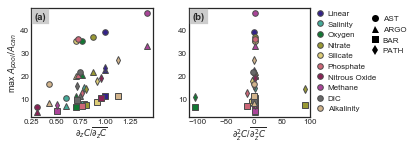

In [82]:
sns.set_style('white')
sns.set_context('paper')
fig=plt.figure(figsize=(5,2))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.3)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]

for tr, tr_lab, factor, ii, col in zip(tracers, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run, lab_exp, can_area,exp,grad,curv,grad0,curv0 in zip(exp_files, 
                                                                      runs,
                                                                      labels_exp,
                                                                      can_Area,exps,
                                                                      sb_grad, sb_curv,
                                                                      sb_grad0, sb_curv0):
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 'o', mfc = col, mec='0.3',mew=1, label = tr_lab)
                    ax1.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 'o', mfc = col, mec='0.3',mew=1, label = tr_lab)
                    
                else:
                    ax0.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, '^', mfc = col, mec='0.3',mew=1) 
                    ax1.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, '^', mfc = col, mec='0.3',mew=1) 
                    
            else:
                if lab_exp=='BAR':
                    ax0.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 's', mfc = col, mec='0.3',mew=1) 
                    ax1.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 's', mfc = col, mec='0.3',mew=1) 
                    
                else:
                    ax0.plot(grad0[ii]/grad[ii],np.nanmax(area[ii,:])/can_area, 'd', mfc = col, mec='0.3',mew=1) 
                    ax1.plot(curv0[ii]/curv[ii],np.nanmax(area[ii,:])/can_area, 'd', mfc = col, mec='0.3',mew=1) 
                        
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)

ax0.legend(bbox_to_anchor=(2.9,1.05), handletextpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]


ax1.legend(handles=legend_elements, bbox_to_anchor=(1.85,1), handletextpad=0)
ax0.text(0.03,0.9,'(a)',fontweight='bold',transform=ax0.transAxes,bbox=dict(boxstyle="square",
                                                                             ec='0.8',
                                                                             fc='0.8'))
ax1.text(0.03,0.9,'(b)',fontweight='bold',transform=ax1.transAxes,bbox=dict(boxstyle="square",
                                                                             ec='0.8',fc='0.8'))
ax1.set_xlabel(r'$\partial^2_zC$/$\overline{\partial^2_zC}$', labelpad=0)
ax0.set_xlabel(r'$\partial_zC$/$\overline{\partial_zC}$', labelpad=0)
ax0.set_ylabel('max $A_{pool}/A_{can}$', labelpad=0)
                                                                             

plt.savefig('pool_area_vs_geom_local.eps',format='eps', bbox_inches='tight')